In [1]:
%pylab inline
rcParams['figure.figsize'] = (12, 8)

Populating the interactive namespace from numpy and matplotlib


# Cython Varpro Module

I've started making a cython-based variable projection code. First I have to make sure I can import it and it actually works.

In [2]:
import varpro
varpro.test('hello world')

hello world


Next, I'm generating some multiresponse data.

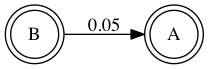

In [3]:
import networkx as nx
import pydot_ng as pydot
from IPython.display import Image
from scipy.linalg import expm

g = nx.DiGraph(name='reaction')
g.add_nodes_from(['A', 'B'])
g.add_edges_from(
    [
     ('B', 'A', {'k': 0.05}),
    ])

# Setup stuff
d = pydot.Dot(graph_name='mechanism', rankdir='LR', size='"8,5"')
d.set_prog('dot')
d.set_node_defaults(shape='doublecircle')

# add nodes from networkx
for node,attr in sorted(g.nodes(data=True)):
    d.add_node(pydot.Node(node))
# ... and edges
for a,b,attr in g.edges(data=True):
    d.add_edge(pydot.Edge(a,b, label='{!s}'.format(attr['k'])))

#print(d.to_string())
d.write_png('test.png')

K = nx.attr_matrix(g, edge_attr='k', rc_order=['A', 'B'])
M = np.asarray(K.T)
M[np.diag_indices(g.number_of_nodes())] = -np.sum(K, axis=1).flatten()
#E = np.array([[1, 0, 0]]) # absorption at a given wavelength
#phi = 1 # quantum yield
t = np.linspace(0, 50, 1000)
Ct = np.zeros((M.shape[0], *t.shape))
C0 = np.array([0, 1])
for i,val in enumerate(t):
    Ct[:, i] = np.dot(expm(M*val), C0)
    
Image('test.png')

## Testing fitting

In [4]:
tmp = varpro.ResponseBlock(Ct[0], 2, 2)
tmp.update_model(np.array([0.]))

Calculating default model matrix...done
Estimating linear parameters...svd...sigma...Apinv...beta...yh...done
Smallest singular value 1.4888e-13


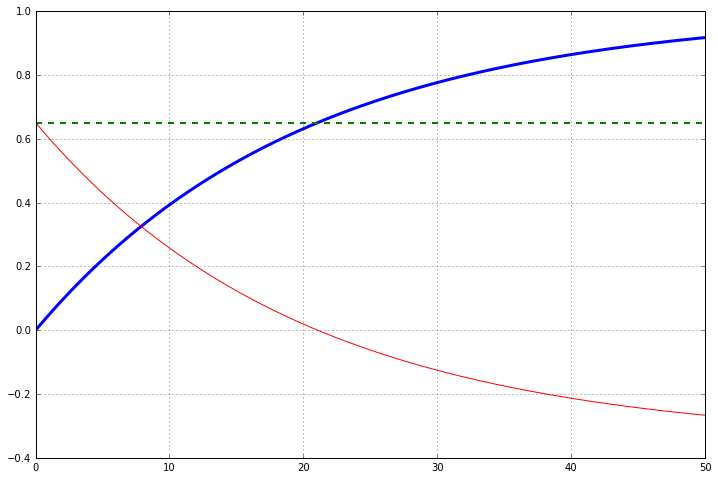

In [5]:
plot(t, tmp.measured, lw=3)
plot(t, tmp.estimated, lw=2, ls='--')
plot(t, tmp.residuals)
grid()

In [6]:
a = varpro.SingleExpBlock(Ct[0], t)
b = varpro.SingleExpBlock(Ct[1], t)

Calculating SingleExpBlock model matrix...done
Estimating linear parameters...svd...sigma...Apinv...beta...yh...done
Smallest singular value 6.9526
Calculating SingleExpBlock model matrix...done
Estimating linear parameters...svd...sigma...Apinv...beta...yh...done
Smallest singular value 6.9526
[ 0.77188974 -1.04192692]
[ 0.22811026  1.04192692]


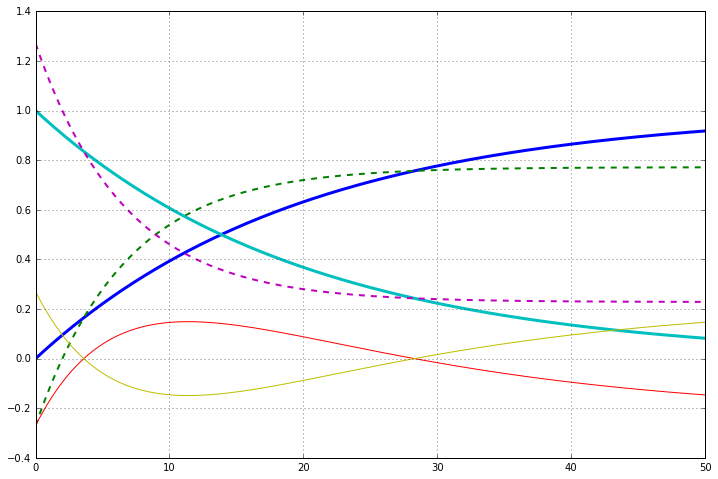

In [7]:
a.update_model(np.array([0.15]))
b.update_model(np.array([0.15]))
for m in [a, b]:
    plot(t, m.measured, lw=3)
    plot(t, m.estimated, lw=2, ls='--')
    plot(t, m.residuals)
    print(m.beta)
grid()

In [8]:
a.update_model(np.array([0.05]), eval_jac=True)
b.update_model(np.array([0.05]), eval_jac=True)

Calculating SingleExpBlock model matrix...done
Estimating linear parameters...svd...sigma...Apinv...beta...yh...done
Smallest singular value 7.4841
Evaluating varpro jacobian...scaling (1,0)...A...B...J...merging...done
Calculating SingleExpBlock model matrix...done
Estimating linear parameters...svd...sigma...Apinv...beta...yh...done
Smallest singular value 7.4841
Evaluating varpro jacobian...scaling (1,0)...A...B...J...merging...done


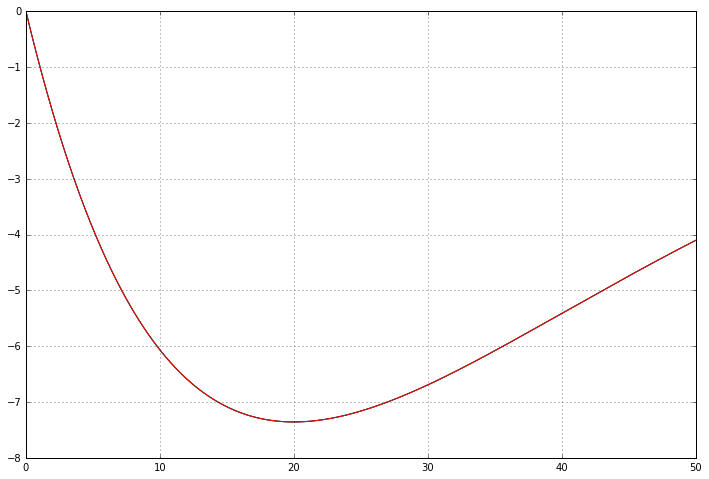

In [9]:
plot(t, b.mjacobian)
plot(t, -t*np.exp(-t*0.05))
plot(t, -t*b.estimated)
grid()

# try nonlinear fitting

Now that something is working, I'll try putting the model into levmar

In [10]:
import levmar

In [11]:
def model(p0, response_block):
    response_block.update_model(p0)
    return response_block.estimated
def jac(p0, response_block):
    response_block.update_model(p0, eval_jac=True)
    return response_block.jacobian

In [12]:
noise = np.random.normal(0, 0.2, size=Ct.shape)
inp = Ct[0] + noise[0]
mblock = varpro.SingleExpBlock(inp, t)
p0 = np.array([0.5])
boundaries = [(0, 10)]
pfit, jtj, info = levmar.levmar_bc(model, p0, mblock.measured, args=(mblock,), bc=boundaries)

Calculating SingleExpBlock model matrix...done
Estimating linear parameters...svd...sigma...Apinv...beta...yh...done
Smallest singular value 4.3377
Calculating SingleExpBlock model matrix...done
Estimating linear parameters...svd...sigma...Apinv...beta...yh...done
Smallest singular value 4.3377
Calculating SingleExpBlock model matrix...done
Estimating linear parameters...svd...sigma...Apinv...beta...yh...done
Smallest singular value 4.3377
Calculating SingleExpBlock model matrix...done
Estimating linear parameters...svd...sigma...Apinv...beta...yh...done
Smallest singular value 4.3375
Calculating SingleExpBlock model matrix...done
Estimating linear parameters...svd...sigma...Apinv...beta...yh...done
Smallest singular value 5.0183
Calculating SingleExpBlock model matrix...done
Estimating linear parameters...svd...sigma...Apinv...beta...yh...done
Smallest singular value 5.0183
Calculating SingleExpBlock model matrix...done
Estimating linear parameters...svd...sigma...Apinv...beta...yh...

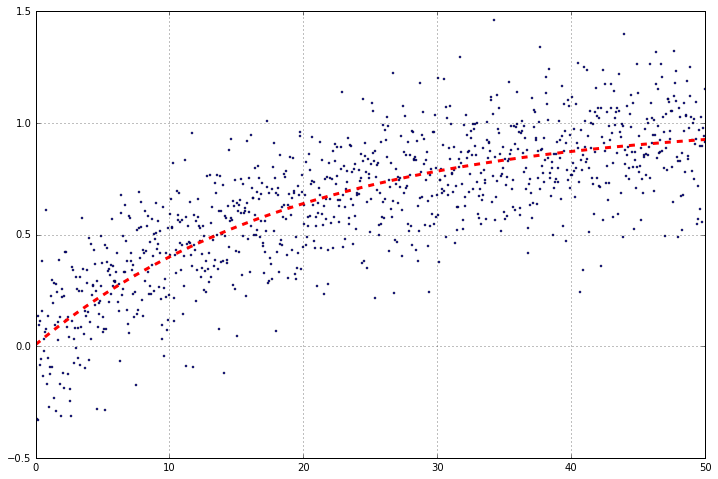

In [13]:
plot(t, mblock.measured, lw=0, marker='o', markersize=2)
plot(t, mblock.estimated, lw=3, ls='--', c='r')
grid()

## Now try fitting multiple responses by merging blocks

In [14]:
def model(p0, response_blocks):
    total_estimate = []
    for block in response_blocks:
        block.update_model(p0)
        total_estimate.append(block.estimated)
    return np.concatenate(total_estimate)

def jac(p0, response_blocks):
    total_jacobian = []
    for block in response_blocks:
        block.update_model(p0, eval_jac=True)
        total_jacobian.append(block.jacobian)
    return np.concatenate(total_jacobian)

def measured_response(response_blocks):
    total_measured = []
    for block in response_blocks:
        total_measured.append(block.measured)
    return np.concatenate(total_measured)

Calculating SingleExpBlock model matrix...done
Estimating linear parameters...svd...sigma...Apinv...beta...yh...done
Smallest singular value 1.7321
Calculating SingleExpBlock model matrix...done
Estimating linear parameters...svd...sigma...Apinv...beta...yh...done
Smallest singular value 1.7321
Calculating SingleExpBlock model matrix...done
Estimating linear parameters...svd...sigma...Apinv...beta...yh...done
Smallest singular value 1.7321
Evaluating varpro jacobian...scaling (1,0)...A...B...J...merging...done
Calculating SingleExpBlock model matrix...done
Estimating linear parameters...svd...sigma...Apinv...beta...yh...done
Smallest singular value 1.7321
Evaluating varpro jacobian...scaling (1,0)...A...B...J...merging...done


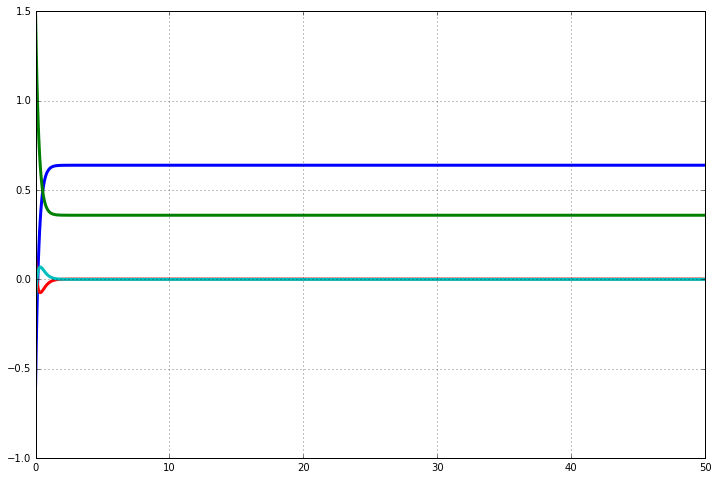

In [15]:
noise = np.random.normal(0, 0.1, size=Ct.shape)
inp = Ct + noise
a = varpro.SingleExpBlock(inp[0], t)
b = varpro.SingleExpBlock(inp[1], t)
p0 = np.array([4.])
boundaries = [(0, 10)]
plot(t, model(p0, [a, b]).reshape(2, -1).T, lw=3)
plot(t, jac(p0, [a,b]).reshape(2, -1).T, lw=3)
grid()

In [16]:
pfit, jtj, info = levmar.levmar_bc(model, p0, measured_response([a,b]), args=([a,b],), bc=boundaries)
info

Calculating SingleExpBlock model matrix...done
Estimating linear parameters...svd...sigma...Apinv...beta...yh...done
Smallest singular value 1.7321
Calculating SingleExpBlock model matrix...done
Estimating linear parameters...svd...sigma...Apinv...beta...yh...done
Smallest singular value 1.7321
Calculating SingleExpBlock model matrix...done
Estimating linear parameters...svd...sigma...Apinv...beta...yh...done
Smallest singular value 1.7321
Calculating SingleExpBlock model matrix...done
Estimating linear parameters...svd...sigma...Apinv...beta...yh...done
Smallest singular value 1.7321
Calculating SingleExpBlock model matrix...done
Estimating linear parameters...svd...sigma...Apinv...beta...yh...done
Smallest singular value 1.7321
Calculating SingleExpBlock model matrix...done
Estimating linear parameters...svd...sigma...Apinv...beta...yh...done
Smallest singular value 1.7321
Calculating SingleExpBlock model matrix...done
Estimating linear parameters...svd...sigma...Apinv...beta...yh...

(136.8795406419418,
 (19.28380218753992,
  3.8625801468405996e-07,
  9.498357964806154e-21,
  2.1319174381034466e-07),
 7,
 'Stop by small Dp',
 23,
 7,
 7)

Calculating SingleExpBlock model matrix...done
Estimating linear parameters...svd...sigma...Apinv...beta...yh...done
Smallest singular value 7.5246
Calculating SingleExpBlock model matrix...done
Estimating linear parameters...svd...sigma...Apinv...beta...yh...done
Smallest singular value 7.5246
[ 0.05121201]
[ 0.9941581  -1.00529383]
[ 0.01416801  0.97209122]


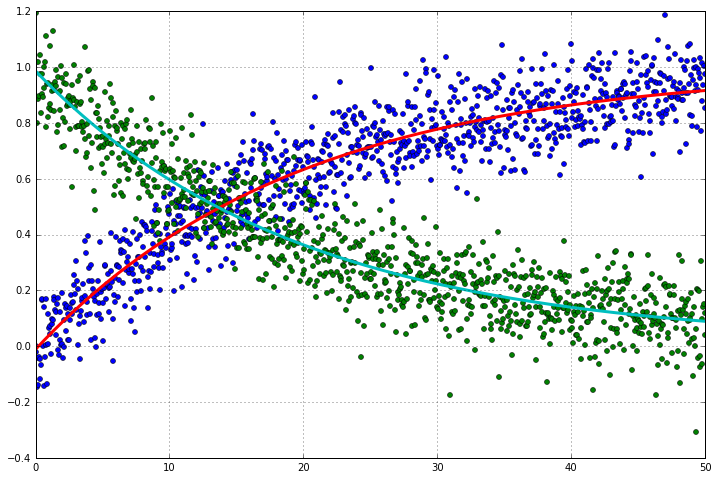

In [17]:
plot(t, measured_response([a, b]).reshape(2, -1).T, lw=0, marker='o', markersize=5)
plot(t, model(pfit, [a, b]).reshape(2, -1).T, lw=3)
#plot(t, jac(p0, [a,b]).reshape(2, -1).T, lw=3)
grid()
print(pfit)
print(a.beta)
print(b.beta)